In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, adjusted_rand_score, silhouette_score
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest, RFE, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split


## Загрузка и подготовка данных

Работаем с датасетом SMS.tsv.
* векторизуем тексты через CountVectorizer 
* делим на train/test


In [2]:
# загрузка из файла
def load_sms_tsv(path="SMS.tsv"):
    df = pd.read_csv(path, sep="\t")
    df = df.dropna(subset=["text", "class"]).reset_index(drop=True)
    return df

# преобразование списка текстов в матрицу признаков
def vectorize_texts(texts, max_features=5000):
    vectorizer = CountVectorizer(stop_words="english", max_features=max_features)
    X = vectorizer.fit_transform(texts)
    return X, vectorizer


def make_train_test(X, y, test_size=0.3, random_state=10):
    return train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y  # чтобы пропорции классов сохранились
    )


df = load_sms_tsv("SMS.tsv")

X, vec = vectorize_texts(df["text"].astype(str).tolist(), max_features=5000)
y = df["class"].astype(str).values

X_train, X_test, y_train, y_test = make_train_test(X, y, test_size=0.3, random_state=10)

feature_names = vec.get_feature_names_out()

print("X_train shape:", X_train.shape)
print("Классы:", np.unique(y_train))


X_train shape: (3900, 5000)
Классы: ['ham' 'spam']


## Реализации выбора признаков

Три подхода:
- **Фильтр**: считаем важность слова отдельно (chi²) и берём топ-N.
- **Обёртка**: жадно добавляем признаки, оценивая качество модели.
- **Встроенный**: модель сама «зануляет» ненужные признаки (L1).


In [3]:

def select_top_words(feature_names, indices, n=30):
    idx = np.asarray(indices)[:n]
    return feature_names[idx]


# Фильтр 
# считаем важность слова отдельно и берём топ-N.
def select_features_filter_chi2(X, y, n=30):
    scores, _ = chi2(X, y)
    order = np.argsort(scores)[::-1]  # по убыванию
    return order[:n]


# Обёртка 
# жадно добавляем признаки, оценивая качество модели
def select_features_wrapper_greedy(X, y, n=30, prefilter_k=200, random_state=42):
    rng = np.random.default_rng(random_state)

    # Предфильтр чтобы не перебирать всё
    chi2_scores, _ = chi2(X, y)
    candidates = np.argsort(chi2_scores)[::-1][:prefilter_k]
    X_small = X[:, candidates]

    selected_local = []
    remaining = list(range(X_small.shape[1]))

    clf = LogisticRegression(solver="liblinear")

    while len(selected_local) < n and remaining:
        best_feat = None
        best_score = -1.0

        rng.shuffle(remaining)

        for feat in remaining:
            temp = selected_local + [feat]
            X_tmp = X_small[:, temp]

            clf.fit(X_tmp, y)
            score = clf.score(X_tmp, y)

            if score > best_score:
                best_score = score
                best_feat = feat

        selected_local.append(best_feat)
        remaining.remove(best_feat)

    # возвращаем индексы признаков в исходной матрице X
    return candidates[np.array(selected_local)]


# Встроенный LogisticRegression с L1 
# автоматически обнуляет неважные признаки при обучении
def select_features_embedded_l1(X, y, n=30):
    clf = LogisticRegression(penalty="l1", solver="liblinear")
    clf.fit(X, y)

    coefs = clf.coef_[0]
    order = np.argsort(np.abs(coefs))[::-1]  # важность по |весу|
    return order[:n]


In [4]:

N_TOP = 30

idx_filter   = select_features_filter_chi2(X_train, y_train, n=N_TOP)
idx_wrapper  = select_features_wrapper_greedy(X_train, y_train, n=N_TOP, prefilter_k=200, random_state=42)
idx_embedded = select_features_embedded_l1(X_train, y_train, n=N_TOP)

print("Топ-30 (Фильтр):")
print(select_top_words(feature_names, idx_filter), "\n")

print("Топ-30 (Обёртка):")
print(select_top_words(feature_names, idx_wrapper), "\n")

print("Топ-30 (Регрессионный):")
print(select_top_words(feature_names, idx_embedded))


Топ-30 (Фильтр):
['hole' 'edu' 'duchess' 'honesty' 'dsn' 'hoo' 'hoody' 'hooked' 'hopeful'
 'hostile' 'hotmix' 'hottest' 'housewives' 'housing' 'jb' 'hui' 'huiming'
 'hum' 'agalla' 'humans' 'hungover' 'hunt' 'hype' 'ias' 'ibored'
 'ibuprofens' 'icic' 'donate' 'idu' 'hppnss'] 

Топ-30 (Обёртка):
['872' 'hates' 'jaykwon' 'happiest' 'housewives' 'includes' 'gained'
 'gage' 'funk' 'hen' 'interviews' 'hopeful' 'heroes' 'hoody' 'rcv' 'gays'
 'ibored' 'housing' 'hesitant' 'hostile' 'ee' 'flame' 'fond' 'irulinae'
 'telephone' 'idu' 'footbl' 'fm' 'invention' 'hitman'] 

Топ-30 (Регрессионный):
['claim' 'uk' 'service' '150p' 'sept' 'members' '0800' 'voicemail'
 'ringtone' 'services' '50' 'cs' 'fullonsms' 'txt' 'reveal' '800' 'sale'
 'chat' 'mobile' 'video' '40' 'filthy' 'min' 'rate' 'won' 'http' 'ladies'
 '18' 'tones' 'com']


## Оценка классификаторов 


In [5]:

def slice_features(X, indices):
    return X[:, np.asarray(indices)]

# Обсучение можелей и вывод
def evaluate_models(X_train, y_train, X_test, y_test, models):
    rows = []
    for name, model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        acc = accuracy_score(y_test, pred)
        f1  = f1_score(y_test, pred, pos_label="ham")

        rows.append((name, acc, f1))
        print(f"{name:>18s} | acc={acc:.4f} | F1(ham)={f1:.4f}")
    return rows


models = [
    ("LogReg",       LogisticRegression(solver="liblinear")),
    ("RandomForest", RandomForestClassifier(random_state=42)),
    ("DecisionTree", DecisionTreeClassifier(random_state=42)),
]

print("Без отбора признаков")
_ = evaluate_models(X_train, y_train, X_test, y_test, models)

print("\nПосле фильтра")
_ = evaluate_models(slice_features(X_train, idx_filter), y_train,
                slice_features(X_test,  idx_filter), y_test, models)

print("\nПосле обёртки")
_ = evaluate_models(slice_features(X_train, idx_wrapper), y_train,
                slice_features(X_test,  idx_wrapper), y_test, models)

print("\nПосле регрессионного")
_ = evaluate_models(slice_features(X_train, idx_embedded), y_train,
                slice_features(X_test,  idx_embedded), y_test, models)


Без отбора признаков
            LogReg | acc=0.9815 | F1(ham)=0.9894
      RandomForest | acc=0.9773 | F1(ham)=0.9870
      DecisionTree | acc=0.9629 | F1(ham)=0.9787

После фильтра
            LogReg | acc=0.8660 | F1(ham)=0.9282
      RandomForest | acc=0.8660 | F1(ham)=0.9282
      DecisionTree | acc=0.8660 | F1(ham)=0.9282

После обёртки
            LogReg | acc=0.8660 | F1(ham)=0.9282
      RandomForest | acc=0.8660 | F1(ham)=0.9282
      DecisionTree | acc=0.8660 | F1(ham)=0.9282

После регрессионного
            LogReg | acc=0.9510 | F1(ham)=0.9722
      RandomForest | acc=0.9533 | F1(ham)=0.9734
      DecisionTree | acc=0.9533 | F1(ham)=0.9734


* Без отбора: максимальное качество, модель использует всю информацию.

* Фильтр и обёртка: сильная потеря качества, выбранные признаки оказались неинформативными.

* Регрессионный: лучший из методов отбора потому что качество снизилось умеренно и осталось близким к исходному.

## Библиотечные методы выбора признаков (sklearn)

In [6]:
# Фильтр 
kbest = SelectKBest(score_func=mutual_info_classif, k=N_TOP)
kbest.fit(X_train, y_train)
idx_filter_lib = kbest.get_support(indices=True)

print("Топ-30 (фильтр):")
print(select_top_words(feature_names, idx_filter_lib), "\n")

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rfe = RFE(estimator=rf, n_features_to_select=N_TOP, step=0.1)
rfe.fit(X_train, y_train)
idx_wrapper_lib = np.where(rfe.support_)[0]

print("Топ-30 (обёртка):")
print(select_top_words(feature_names, idx_wrapper_lib), "\n")

# встроенный, GradientBoosting 
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

sfm = SelectFromModel(gb, max_features=N_TOP, prefit=True)
idx_embedded_lib = sfm.get_support(indices=True)

print("Топ-30 (встроенный, GradientBoosting):")
print(select_top_words(feature_names, idx_embedded_lib))


Топ-30 (фильтр):
['1000' '150p' '16' '18' '50' '500' 'cash' 'claim' 'com' 'contact' 'cs'
 'customer' 'draw' 'free' 'guaranteed' 'mobile' 'nokia' 'prize' 'reply'
 'service' 'stop' 'text' 'tone' 'txt' 'uk' 'ur' 'urgent' 'win' 'won' 'www'] 

Топ-30 (обёртка):
['150p' '16' '18' '50' '500' 'cash' 'claim' 'com' 'contact' 'cs'
 'customer' 'free' 'guaranteed' 'http' 'latest' 'mobile' 'nokia' 'prize'
 'reply' 'ringtone' 'service' 'stop' 'text' 'txt' 'uk' 'urgent' 'video'
 'win' 'won' 'www'] 

Топ-30 (встроенный, GradientBoosting):
['150p' '18' '2003' '50' '800' 'admirer' 'cash' 'chat' 'claim' 'code'
 'com' 'contact' 'customer' 'free' 'http' 'mobile' 'private' 'prize'
 'reply' 'ringtone' 'sae' 'service' 'services' 'stop' 'text' 'txt' 'uk'
 'video' 'win' 'www']


## Оценка классификаторов после библиотечного отбора


In [7]:

print("Без отбора признаков")
_ = evaluate_models(X_train, y_train, X_test, y_test, models)

print("\nПосле sklearn-фильтра")
_ = evaluate_models(slice_features(X_train, idx_filter_lib), y_train,
                slice_features(X_test,  idx_filter_lib), y_test, models)

print("\nПосле sklearn-обёртки")
_ = evaluate_models(slice_features(X_train, idx_wrapper_lib), y_train,
                slice_features(X_test,  idx_wrapper_lib), y_test, models)

print("\nПосле встроенного (градиентного бустинга)")
_ = evaluate_models(slice_features(X_train, idx_embedded_lib), y_train,
                slice_features(X_test,  idx_embedded_lib), y_test, models)


Без отбора признаков
            LogReg | acc=0.9815 | F1(ham)=0.9894
      RandomForest | acc=0.9773 | F1(ham)=0.9870
      DecisionTree | acc=0.9629 | F1(ham)=0.9787

После sklearn-фильтра
            LogReg | acc=0.9563 | F1(ham)=0.9753
      RandomForest | acc=0.9569 | F1(ham)=0.9756
      DecisionTree | acc=0.9545 | F1(ham)=0.9743

После sklearn-обёртки
            LogReg | acc=0.9563 | F1(ham)=0.9753
      RandomForest | acc=0.9581 | F1(ham)=0.9763
      DecisionTree | acc=0.9545 | F1(ham)=0.9743

После встроенного (градиентного бустинга)
            LogReg | acc=0.9575 | F1(ham)=0.9760
      RandomForest | acc=0.9611 | F1(ham)=0.9779
      DecisionTree | acc=0.9587 | F1(ham)=0.9766


* Без отбора -- наилучшее качество.

* Sklearn-фильтр и обёртка -- небольшое снижение качества.

* Встроенный (градиентный бустинг) -- лучший из методов отбора, качество ближе всего к исходному.

## Кластеризация -- реализация KMeans


In [8]:
# Случайный выбор k точек -- начальные центроиды
def kmeans_init_centroids(X, k, random_state=42):
    rng = np.random.default_rng(random_state)
    idx = rng.choice(X.shape[0], size=k, replace=False)
    return X[idx].copy()

# Назначение ближайших центроидов
def kmeans_assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    return np.argmin(distances, axis=1)

# Пересчёт центроидов (берется среднее по кластеру)
def kmeans_update_centroids(X, labels, k):
    d = X.shape[1]
    new_c = np.zeros((k, d), dtype=float)
    for j in range(k):
        mask = (labels == j)
        if np.any(mask):
            new_c[j] = X[mask].mean(axis=0)
        else:
            new_c[j] = 0.0
    return new_c

# Обучение KMeans и получкние разбиения на кластеры
def kmeans_fit(X, k=2, max_iter=200, tol=1e-4, random_state=42):
    centroids = kmeans_init_centroids(X, k, random_state=random_state)
    for _ in range(max_iter):
        labels = kmeans_assign_clusters(X, centroids)
        new_centroids = kmeans_update_centroids(X, labels, k)

        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids

        if shift <= tol:
            break
    return labels, centroids

# Оценива ние качества кластеризации с помощью метрик ARI и Silhouette
def clustering_report(X_dense, y_true, title=""):
    labels, _ = kmeans_fit(X_dense, k=2, max_iter=200, tol=1e-4, random_state=42)

    print(title)

    # Внешняя метрика: сравниваем кластеры с реальными классами
    ari = adjusted_rand_score(y_true, labels)
    print(f"ARI = {ari:.4f}")

    # Внутренняя метрика Silhouette определена только если кластеров >= 2
    if len(np.unique(labels)) >= 2:
        sil = silhouette_score(X_dense, labels)
        print(f"Silhouette = {sil:.4f}")
    else:
        print("Silhouette не вычисляется: получился один кластер")

    return labels




# Для кластеризации переводим разреженную матрицу в dense
X_train_dense = X_train.toarray()

labels_base = clustering_report(X_train_dense, y_train, title="Кластеризация без отбора")


Кластеризация без отбора
ARI = -0.0004
Silhouette = 0.0077


In [9]:

# После фильтра
X_filter_dense = slice_features(X_train, idx_filter).toarray()
labels_filter = clustering_report(X_filter_dense, y_train, title="Кластеризация после фильтра")

# После обёртки
X_wrapper_dense = slice_features(X_train, idx_wrapper).toarray()
labels_wrapper = clustering_report(X_wrapper_dense, y_train, title="Кластеризация после обёртки")

# После встроенного
X_embedded_dense = slice_features(X_train, idx_embedded).toarray()
labels_embedded = clustering_report(X_embedded_dense, y_train, title="Кластеризация после встроенного")


Кластеризация после фильтра
ARI = 0.0000
Silhouette не вычисляется: получился один кластер
Кластеризация после обёртки
ARI = 0.0000
Silhouette не вычисляется: получился один кластер
Кластеризация после встроенного
ARI = 0.5160
Silhouette = 0.8225


* Без отбора: ARI почти ноль и Silhouette почти ноль. Значит, явных кластеров почти нет, KMeans делит данные плохо.

* После фильтра и после обертки: получился один кластер, поэтому Silhouette не считается. Это значит, что после такого отбора признаки стали слишком слабыми для кластеризации.

* После встроенного: ARI 0.516 и Silhouette 0.8229. Это уже хороший результат: данные хорошо делятся на два кластера, и эти кластеры заметно совпадают с реальными классами.

## Визуализация для PCA и tSNE


In [13]:
# Уменьшаем размерность до 2D
def reduce_2d(X_dense, method="pca", random_state=42):
    # если все объекты почти одинаковые, не запускаем ни PCA, ни tSNE
    if np.allclose(X_dense.var(axis=0).sum(), 0.0):
        return np.zeros((X_dense.shape[0], 2))

    if method == "pca":
        reducer = PCA(n_components=2)
        return reducer.fit_transform(X_dense)

    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=random_state, init="pca", learning_rate="auto")
        return reducer.fit_transform(X_dense)

    raise ValueError("method должен быть 'pca' или 'tsne'")


def plot_two_views(X_2d, y_true, y_cluster, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # нужно перевести строки в числа для окраски
    y_true_num = pd.factorize(y_true)[0]
    axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=y_true_num, s=10)
    axes[0].set_title(title + ", Реальные классы")

    axes[1].scatter(X_2d[:, 0], X_2d[:, 1], c=y_cluster, s=10)
    axes[1].set_title(title + ", Кластеры")

    plt.tight_layout()
    plt.show()


def reduce_and_plot(X_dense, y_true, y_cluster, selection_name="Без отбора"):
    # если нет разброса, рисовать бессмысленно
    if np.allclose(X_dense.var(axis=0).sum(), 0.0):
        print(f"{selection_name}: визуализация не строится, данные почти одинаковые (нет дисперсии).")
        return

    for method in ["pca", "tsne"]:
        X_2d = reduce_2d(X_dense, method=method, random_state=42)
        plot_two_views(X_2d, y_true, y_cluster, title=f"{method.upper()} ({selection_name})")


In [14]:

# Подготовка данных для визуализации (запускать перед reduce_and_plot)

# 1) dense-матрицы
X_train_dense = X_train.toarray()
X_filter_dense = slice_features(X_train, idx_filter).toarray()
X_wrapper_dense = slice_features(X_train, idx_wrapper).toarray()
X_embedded_dense = slice_features(X_train, idx_embedded).toarray()

# 2) если метки кластеров еще не посчитаны, считаем
labels_base = clustering_report(X_train_dense, y_train, title="Кластеризация без отбора")
labels_filter = clustering_report(X_filter_dense, y_train, title="Кластеризация после фильтра")
labels_wrapper = clustering_report(X_wrapper_dense, y_train, title="Кластеризация после обертки")
labels_embedded = clustering_report(X_embedded_dense, y_train, title="Кластеризация после встроенного")


Кластеризация без отбора
ARI = -0.0004
Silhouette = 0.0077
Кластеризация после фильтра
ARI = 0.0000
Silhouette не вычисляется: получился один кластер
Кластеризация после обертки
ARI = 0.0000
Silhouette не вычисляется: получился один кластер
Кластеризация после встроенного
ARI = 0.5160
Silhouette = 0.8225


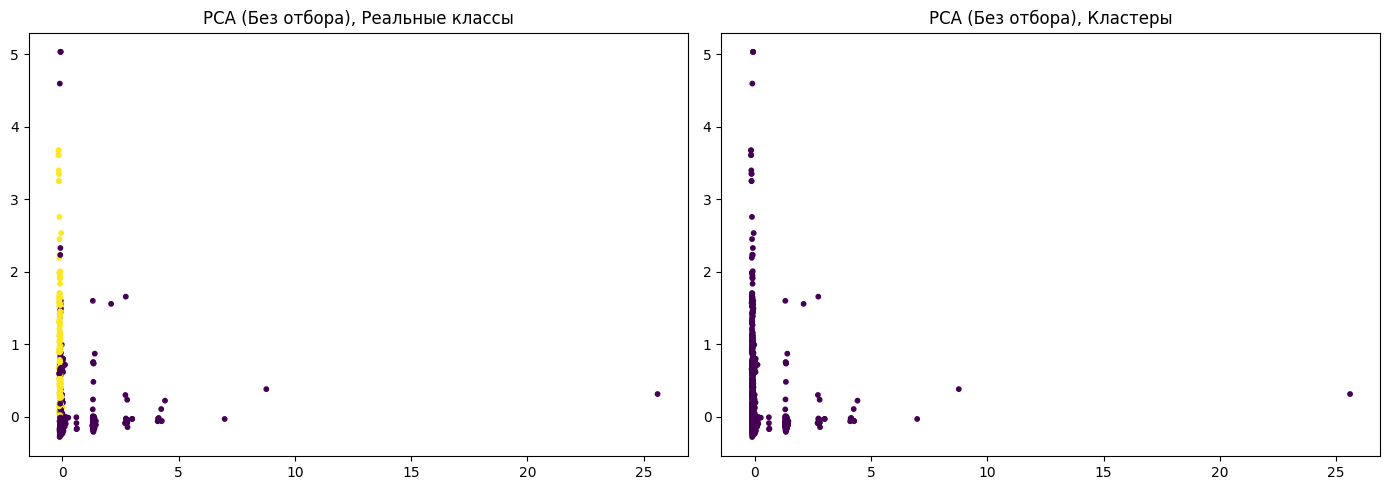

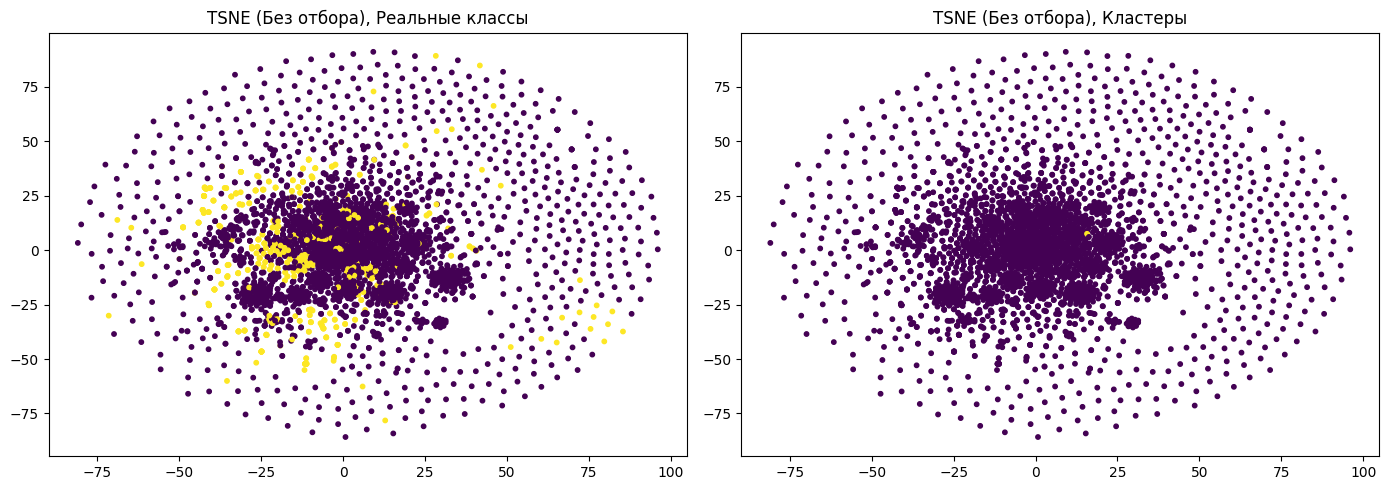

Фильтр: визуализация не строится, данные почти одинаковые (нет дисперсии).
Обёртка: визуализация не строится, данные почти одинаковые (нет дисперсии).


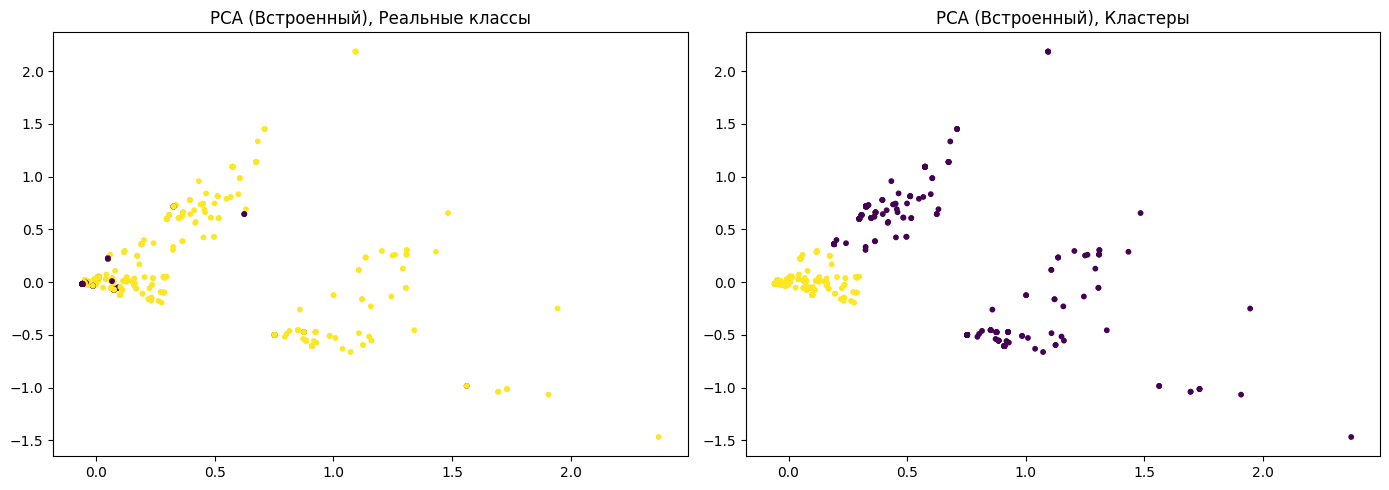

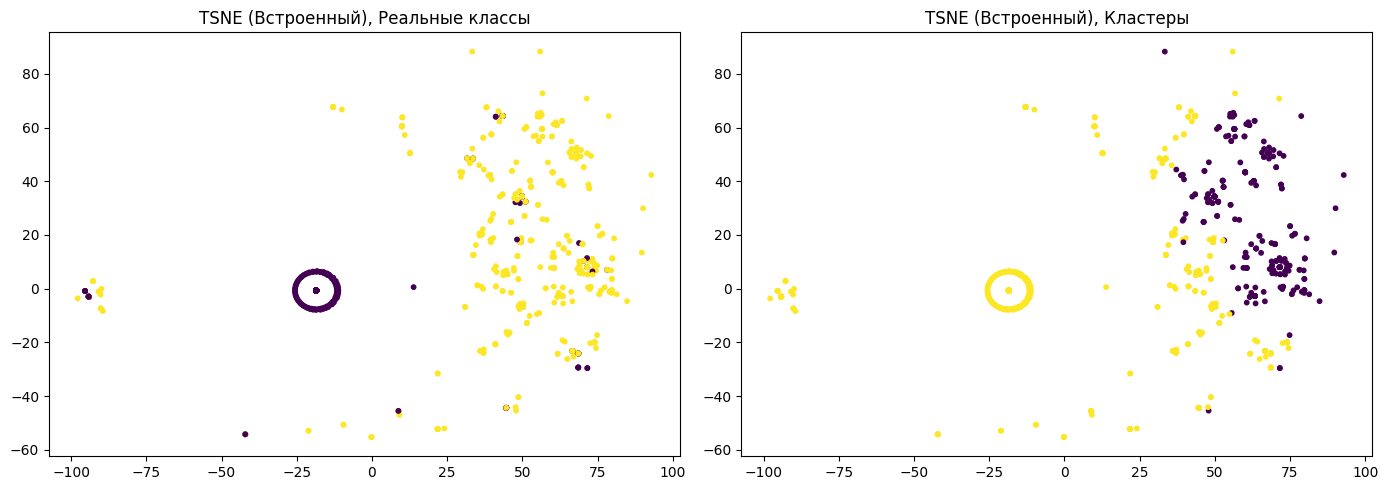

In [15]:

# Без отбора
reduce_and_plot(X_train_dense, y_train, labels_base, selection_name="Без отбора")

# После фильтра
reduce_and_plot(X_filter_dense, y_train, labels_filter, selection_name="Фильтр")

# После обёртки
reduce_and_plot(X_wrapper_dense, y_train, labels_wrapper, selection_name="Обёртка")

# После встроенного
reduce_and_plot(X_embedded_dense, y_train, labels_embedded, selection_name="Встроенный")


* Без отбора признаков.
  На PCA и tSNE объекты образуют одно большое облако, и классы сильно перемешаны. Кластеры KMeans почти не совпадают с реальными метками, поэтому разделение визуально слабое.

* После фильтра и после обертки.
**Визуализация не строится**, потому что после отбора признаки дают почти одинаковые векторы для большинства сообщений (почти нет разброса). Это означает, что выбранные признаки плохо подходят для кластеризации и проекции в 2D.

* После встроенного отбора.
На PCA и tSNE появляются более отделимые группы точек. Раскраска по кластерам становится похожей на раскраску по реальным классам, то есть встроенный метод делает представление более “кластеризуемым”.